In [1]:
%reload_ext autoreload
%autoreload 2


import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import torch
import pytorch_lightning as pl
import wandb

import matplotlib.pyplot as plt

import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d

from collections import Counter



    
import allsim.src.infer as infer
import allsim.src.sim as sim
from allsim.src.policies.policy import MELD, MELD_na, FIFO
from allsim.src.outcome.counterfactual_inference import Inference_OrganITE
from allsim.src.outcome.counterfactual_models import OrganITE_Network

from data.data_module import UNOSDataModule, UKRegDataModule

In [2]:
data = 'UNOS'
data_dir = f'../data/{data}'

if data == 'UNOS':
    dm = UNOSDataModule(data_dir, batch_size=256)
    groups_r = [['DGRP_-1', 'DGRP_0', 'DGRP_1']]
    groups_x = [
        ['PATIENT_LOCATION_-1', 'PATIENT_LOCATION_0', 'PATIENT_LOCATION_1', 'PATIENT_LOCATION_2'],
        ['RAB_SURGERY_-1', 'RAB_SURGERY_0', 'RAB_SURGERY_1', 'RAB_SURGERY_2'],
        ['RASCITES_-1', 'RASCITES_0', 'RASCITES_1', 'RASCITES_2', 'RASCITES_3'],
        ['RENAL_SUPPORT_0', 'RENAL_SUPPORT_1', 'RENAL_SUPPORT_2'],
        ['RENCEPH_0', 'RENCEPH_1', 'RENCEPH_2', 'RENCEPH_3'],
        ['RHCV_-1', 'RHCV_0', 'RHCV_1', 'RHCV_2', 'RHCV_3'],
        ['RREN_SUP_-1', 'RREN_SUP_0', 'RREN_SUP_1'],
        ['SEX_0', 'SEX_1']
    ]
else:
    dm = UKRegDataModule(data_dir, batch_size=256)
    groups_r = [['DCOD_0', 'DCOD_10', 'DCOD_11', 'DCOD_12',
       'DCOD_13', 'DCOD_19', 'DCOD_20', 'DCOD_21', 'DCOD_22', 'DCOD_23',
       'DCOD_24', 'DCOD_29', 'DCOD_30', 'DCOD_31', 'DCOD_39', 'DCOD_40',
       'DCOD_41', 'DCOD_42', 'DCOD_43', 'DCOD_44', 'DCOD_45', 'DCOD_49',
       'DCOD_50', 'DCOD_51', 'DCOD_52', 'DCOD_53', 'DCOD_54', 'DCOD_59',
       'DCOD_60', 'DCOD_70', 'DCOD_71', 'DCOD_72', 'DCOD_81', 'DCOD_82',
       'DCOD_85', 'DCOD_88', 'DCOD_90', 'DCOD_98', 'DCOD_99']]
    

dm.prepare_data()
dm.setup(stage='fit')

DATA = pd.concat([dm._test_processed.copy(deep=True), dm._train_processed.copy(deep=True)])
DATA_true = DATA.copy(deep=True)
DATA_true[dm.real_cols] = dm.scaler.inverse_transform(
    DATA_true[dm.real_cols])

patients = DATA_true[dm.x_cols].copy(deep=True)
organs = DATA_true[dm.o_cols].copy(deep=True)

X = patients
O = organs
Y = dm._train_processed.Y


O_indices_in_real_cols = np.where(np.in1d(np.unique(dm.real_cols), O.columns.values))[0]
mean_real_cols_O = dm.scaler.mean_[O_indices_in_real_cols]
scale_real_cols_O = dm.scaler.scale_[O_indices_in_real_cols]
real_cols_indices_in_O = np.where(np.in1d(O.columns.values, np.unique(dm.real_cols)))[0]


X_indices_in_real_cols = np.where(np.in1d(np.unique(dm.real_cols), X.columns.values))[0]
mean_real_cols_X = dm.scaler.mean_[X_indices_in_real_cols]
scale_real_cols_X = dm.scaler.scale_[X_indices_in_real_cols]
real_cols_indices_in_X = np.where(np.in1d(X.columns.values, np.unique(dm.real_cols)))[0]



/Users/jeroenberrevoets/.virtualenvs/scrapsim/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/Users/jeroenberrevoets/.virtualenvs/scrapsim/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# OrganITE
input_dim = dm.size(1)
hidden_dim=16
num_hidden_layers=4
output_dim=6
lr=0.007
gamma=0.79
lambd=0.15
kappa=0.15
weight_decay=0.0006
n_clusters=15
activation_type="leaky_relu"
dropout_prob=0.11
epochs = 10

organite_model = OrganITE_Network(
             input_dim=input_dim,
             hidden_dim=hidden_dim,
             num_hidden_layers=num_hidden_layers,
             output_dim=output_dim,
             lr=lr,
             gamma=gamma,
             lambd=lambd,
             kappa=kappa,
             weight_decay=weight_decay,
             n_clusters=n_clusters,
             activation_type=activation_type,
             dropout_prob=dropout_prob,
).double()

organite_trainer = pl.Trainer(callbacks=[], max_epochs=epochs)
organite_trainer.fit(organite_model, datamodule=dm)

inference_oite = Inference_OrganITE(
    model=organite_model, mean=dm.mean, std=dm.std,
    x_indices_real=real_cols_indices_in_X, r_indices_real=real_cols_indices_in_O,
    x_mean=mean_real_cols_X, x_scale=scale_real_cols_X,
    r_mean=mean_real_cols_O, r_scale=scale_real_cols_O
)

## Train VAE
#input_dim = len(dm.o_cols)
#organite_vae_model_model = OrganITE_Network_VAE(
#         input_dim=input_dim,
#         hidden_dim=hidden_dim,
#         output_dim=output_dim,
#         lr=lr,
#         gamma=gamma,
#         weight_decay=weight_decay,
#).double()

#organite_vae_trainer = pl.Trainer(callbacks=[], max_epochs=epochs)
#organite_vae_trainer.fit(organite_vae_model_model, datamodule=dm)

#inference_oite_vae = Inference_OrganITE_VAE(model=organite_vae_model_model, mean=dm.mean, std=dm.std)

/Users/jeroenberrevoets/.virtualenvs/scrapsim/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:184: LightningDeprecationWarning: DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.")
/Users/jeroenberrevoets/.virtualenvs/scrapsim/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:170: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/jeroenberrevoets/.virtualenvs/scrapsim/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 th

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [6]:
for i in range(10):
    print(inference_oite.infer(
        np.random.rand(46).reshape(1, -1)
    ))

[[50460.61245023]]
[[50664.11220274]]
[[50968.34322805]]
[[50634.94368233]]
[[50552.59033204]]
[[50723.49462203]]
[[50902.15086354]]
[[50728.58629716]]
[[50799.61542397]]
[[50794.99464584]]


In [7]:
# RESOURCES
bins_r = [30, 45, 60]
def condition_function_r(age):
    i = np.where(np.in1d(dm.real_cols, 'DAGE'))[0]
    age=age
    return np.digitize(age, bins=bins_r).item()


condition_r = infer.Condition(
    labels=['DAGE'],
    function=condition_function_r,
    options=len(bins_r) + 1
)

kde_o = infer.KDEDensity(condition=condition_r, K=condition_r.options)
kde_o.fit(O[:15000], one_hot_encoded=groups_r)

In [8]:
# PATIENTS
#bins_x = [
#    X.SERUM_BILIRUBIN.mean() - X.SERUM_BILIRUBIN.std(),
#    X.SERUM_BILIRUBIN.mean(),
#    X.SERUM_BILIRUBIN.mean() + X.SERUM_BILIRUBIN.std()
#]

bins_x = [30, 45, 60]

def condition_function_x(bilir):
    return np.digitize(bilir, bins=bins_x).item()
    
condition_x = infer.Condition(
    labels=['RAGE'],
    function=condition_function_x,
    options=len(bins_x) + 1
)

kde_x = infer.KDEDensity(condition=condition_x, K=condition_x.options)
kde_x.fit(X[:15000], one_hot_encoded=groups_x)

In [9]:
resource_system, patient_system = dict(), dict()


def update_lam_0(t):
    return (1 / (1+np.exp(-(t-450)/150))) * 3

def update_lam_1(t):
    return (1 / (1+np.exp((t-350)/150))) * 2

def update_lam_2(t):
    a = (1 / (1+np.exp((t-150)/150))) * 2
    b = (1 / (1+np.exp(-(t-650)/100))) * 2
    return (a + b)

def update_lam_3(t):
    a = (1 / (1+np.exp(-(t-150)/150)))
    b = (1 / (1+np.exp((t-650)/100)))
    return (a + b)


resource_system[0] = infer.PoissonProcess(update_lam=update_lam_0)
resource_system[1] = infer.PoissonProcess(update_lam=update_lam_1)
resource_system[2] = infer.PoissonProcess(update_lam=update_lam_2)
resource_system[3] = infer.PoissonProcess(update_lam=update_lam_3)


patient_system[3] = infer.PoissonProcess(update_lam=update_lam_0)
patient_system[2] = infer.PoissonProcess(update_lam=update_lam_1)
patient_system[1] = infer.PoissonProcess(update_lam=update_lam_2)
patient_system[0] = infer.PoissonProcess(update_lam=update_lam_3)


In [10]:
resource_process = infer.PoissonSystem(
    density=kde_o, 
    system=resource_system, 
    alpha=lambda t: 5, 
    normalize=True)

patient_process = infer.PoissonSystem(
    density=kde_x, 
    system=patient_system, 
    alpha=lambda t: 7, 
    normalize=True)

In [11]:
import copy

inference_oite.model.eval()

simulation = sim.Sim(
    resource_system=resource_process,
    patient_system=patient_process,
    inference=inference_oite
)

sim_meld = copy.deepcopy(simulation)
sim_meld_na = copy.deepcopy(simulation)
sim_fifo = copy.deepcopy(simulation)


meld = MELD(name='MELD', initial_waitlist=sim_meld._internal_waitlist, dm=dm)
meld_na = MELD_na(name='MELD-Na', initial_waitlist=sim_meld_na._internal_waitlist, dm=dm)
fifo = FIFO(name='FIFO', initial_waitlist=sim_fifo._internal_waitlist, dm=dm)

In [12]:
df_meld = sim_meld.simulate(meld, T=1021)
df_meld_na = sim_meld_na.simulate(meld_na, T=1021)
df_fifo = sim_fifo.simulate(fifo, T=1021)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:23<00:00, 43.76it/s]


MELD avg days alive (303.0, 1235.5979633862416) (313.0, 1227.577261122243) (324.0, 1232.826652958918) (334.0, 1228.2522377917574) (344.0, 1216.471581371641) (354.0, 1213.9879218786962) (364.0, 1204.7916766313406) (374.0, 1193.083512745946) (384.0, 1186.0430196357424) (394.0, 1182.5569396537276) (404.0, 1174.1595658460992) (414.0, 1175.6671713055118) (424.0, 1177.776979798644) (434.0, 1179.4336698137279) (444.0, 1189.3526454326868) (455.0, 1210.108988796926) (465.0, 1208.1822448259559) (475.0, 1197.5572414150706) (485.0, 1192.5452418085385) (495.0, 1193.3371546576873) (505.0, 1188.1009692203459) (515.0, 1201.1091675711882) (525.0, 1205.704038222379) (535.0, 1214.5125510577675) (545.0, 1219.7295576725824) (555.0, 1218.173433325921) (565.0, 1222.9396559172458) (575.0, 1225.317060460282) (585.0, 1225.1306526884036) (595.0, 1226.450386662712) (605.0, 1231.3248979307266) (615.0, 1244.8746522202969) (625.0, 1238.035468912595) (635.0, 1227.4917003354144) (645.0, 1220.615130989517) (655.0, 1213

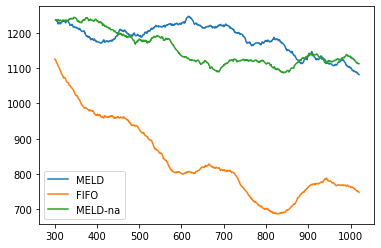

In [14]:
plt.plot(
    df_meld.t.unique(),
    #gaussian_filter1d(donor_df.groupby('t').agg('mean').ttl, sigma=3, axis=0)
    #gaussian_filter1d(df.rolling(window=300, on='t').mean().ttl.to_numpy(), sigma=3, axis=0)
    df_meld.groupby('t').agg('mean').rolling(window=300).mean().ttl,
    label='MELD'
)

plt.plot(
    df_fifo.t.unique(),
    #gaussian_filter1d(donor_df.groupby('t').agg('mean').ttl, sigma=3, axis=0)
    #gaussian_filter1d(df.rolling(window=300, on='t').mean().ttl.to_numpy(), sigma=3, axis=0)
    df_fifo.groupby('t').agg('mean').rolling(window=300).mean().ttl,
    label='FIFO'
)

plt.plot(
    df_meld_na.t.unique(),
    #gaussian_filter1d(donor_df.groupby('t').agg('mean').ttl, sigma=3, axis=0)
    #gaussian_filter1d(df.rolling(window=300, on='t').mean().ttl.to_numpy(), sigma=3, axis=0)
    df_meld_na.groupby('t').agg('mean').rolling(window=300).mean().ttl,
    label='MELD-na'
)

plt.legend()

window=300

print(
    'MELD avg days alive', 
    *list(zip(
        df_meld.t.unique()[np.arange(window, 1020, 10)], 
        df_meld.groupby('t').agg('mean').rolling(window=window).mean().ttl.to_numpy()[np.arange(window, 1020, 10)])),
    sep=' '
)


print(
    'MELD-Na avg days alive', 
    *list(zip(
        df_meld_na.t.unique()[np.arange(window, 1020, 10)], 
        df_meld_na.groupby('t').agg('mean').rolling(window=window).mean().ttl.to_numpy()[np.arange(window, 1020, 10)])),
    sep=' '
)


print(
    'FIFO avg days alive', 
    *list(zip(
        df_fifo.t.unique()[np.arange(window, 1020, 10)], 
        df_fifo.groupby('t').agg('mean').rolling(window=window).mean().ttl.to_numpy()[np.arange(window, 1020, 10)])),
    sep=' '
)


In [ ]:
window = 300
donor_df = df_meld[df_meld.DAGE.notna()]

plt.plot(
    donor_df.t.unique()[np.arange(window, 1020, 10)],
    donor_df.groupby('t').agg('mean').rolling(window=window).mean().DAGE.to_numpy()[np.arange(window, 1020, 10)]
)



plt.plot(
    df.t.unique()[np.arange(window, 1020, 10)],
    donor_df.groupby('t').agg('mean').rolling(window=window).mean().RAGE.to_numpy()[np.arange(window, 1020, 10)]
)


print(
    'DAGE', 
    *list(zip(
        donor_df.t.unique()[np.arange(window, 1020, 10)], 
        donor_df.groupby('t').agg('mean').rolling(window=window).mean().DAGE.to_numpy()[np.arange(window, 1020, 10)])),
    sep=' '
)


print(
    'RAGE', 
    *list(zip(
        donor_df.t.unique()[np.arange(window, 1020, 10)], 
        donor_df.groupby('t').agg('mean').rolling(window=window).mean().RAGE.to_numpy()[np.arange(window, 1020, 10)])),
    sep=' '
)



In [ ]:
np.arange(window, 1020, 10)

In [ ]:
for c in resource_system.keys():
    plt.plot(
        df.t,
        [resource_system[c].update_lam(t) for t in df.t], label=c)
    
    print(
        c, 
        *list(zip(
            np.arange(window, 1020, 10), 
            [resource_system[c].update_lam(t) for t in np.arange(window, 1020, 10)])),
        sep=' '
    )
    print('\n\n')
    
plt.legend()

In [ ]:
for c in patient_system.keys():
    plt.plot(
        df.t,
        [patient_system[c].update_lam(t) for t in df.t], label=c)
plt.legend()

In [ ]:
df

In [ ]:
df[df.DAGE.isna()][['DAGE', 'DBMI', 'INR', 'RSODIUM', 'SERUM_CREATININE', 'SEX_0', 'ttl', 't']]

In [ ]:
plt.plot(
    df.t.unique()[np.arange(window, 1020, 10)],
    donor_df.groupby('t').agg('mean').rolling(window=window).mean().SEX_0.to_numpy()[np.arange(window, 1020, 10)],
    label='M'
)

plt.plot(
    df.t.unique()[np.arange(window, 1020, 10)],
    donor_df.groupby('t').agg('mean').rolling(window=window).mean().SEX_1.to_numpy()[np.arange(window, 1020, 10)],
    label='F'
)





plt.legend()






print(
    'M', 
    *list(zip(
        donor_df.t.unique()[np.arange(window, 1020, 10)], 
        donor_df.groupby('t').agg('mean').rolling(window=window).mean().SEX_0.to_numpy()[np.arange(window, 1020, 10)])),
    sep=" "
)
print('\n\n')

print(
    'F', 
    *list(zip(
        donor_df.t.unique()[np.arange(window, 1020, 10)], 
        donor_df.groupby('t').agg('mean').rolling(window=window).mean().SEX_1.to_numpy()[np.arange(window, 1020, 10)])),
    sep=" "
)
print('\n\n')



In [ ]:
df_meld

In [ ]:
torch.randn(inference_oite.model.input_dim)